<div style="border:solid steelblue 1px; padding: 20px">
    
<font size="4"><p style="text-align:center"><b>Выбор локации для скважины 🛢️</b></p></font>

</div>

# Содержание
1. [Описание данных](#Описание_данных)
2. [EDA](#EDA)
3. [Обучение модели](#Обучение_модели) 
4. [Подготовка к расчёту прибыли](#Подготовка_к_расчёту_прибыли) 
5. [Функция для расчёта прибыли по выбранным скважинам](#Функция_для_расчёта_прибыли_по_выбранным_скважинам) 
6. [Риски и прибыль для каждого региона](#Риски_и_прибыль_для_каждого_региона) 
7. [Вывод](#Вывод)

<div class="alert alert-info">
<font size="4", color = "black"><a name="Описание_данных"><h3>Описание данных</h3></a></font>
    <br /> 
    <font size="3", color = "black">

<div class="alert alert-info">
<font size="4", color = "black">📌 В добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.
    
Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Построим модель для определения региона, где добыча принесёт наибольшую прибыль. 

<ul>
 <li>id — уникальный идентификатор скважины</li>
 <li>f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы)</li>
 <li>product — объём запасов в скважине (тыс. баррелей)</li>
</ul>

<div class="alert alert-info">
<font size="4", color = "black"><a name="EDA"><h3>EDA</h3></a></font>
    <br /> 
    <font size="3", color = "black">

In [1]:
conda install -c conda-forge phik

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import phik
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from phik import report
from scipy import stats as st 
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

<div class="alert alert-info">
<font size="4", color = "black">📌 При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [3]:
BUDGET = 1e10
PRICE = 450000
POINT_ML = 200
POINT_EDA = 500

In [4]:
pth1 = '/datasets/geo_data_0.csv'
pth2 = 'geo_data_0.csv'
if os.path.exists(pth1):
    data_one = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data_one = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [5]:
pth3 = '/datasets/geo_data_1.csv'
pth4 = 'geo_data_1.csv'
if os.path.exists(pth3):
    data_two = pd.read_csv(pth3)
elif os.path.exists(pth4):
    data_two = pd.read_csv(pth4)
else:
    print('Something is wrong')

In [6]:
pth5 = '/datasets/geo_data_2.csv'
pth6 = 'geo_data_2.csv'
if os.path.exists(pth5):
    data_three = pd.read_csv(pth5)
elif os.path.exists(pth6):
    data_three = pd.read_csv(pth6)
else:
    print('Something is wrong')

In [7]:
data_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
data_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
data_three.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
data_one.duplicated().sum()

0

In [11]:
data_two.duplicated().sum()

0

In [12]:
data_three.duplicated().sum()

0

In [13]:
def drop_col(data, field):
    '''функция удаляет столбец в датасете'''
    return data.drop([field], axis = 1)

In [14]:
data_one = drop_col(data_one, 'id')
data_two = drop_col(data_two, 'id')
data_three = drop_col(data_three, 'id')


In [15]:
data_train_one, data_valid_one = train_test_split(data_one, test_size=0.25, random_state=42, shuffle = True)
features_train_one = data_train_one.drop(['product'], axis=1)
target_train_one = data_train_one['product']
features_valid_one = data_valid_one.drop(['product'], axis=1)
target_valid_one = data_valid_one['product']
print(features_train_one.shape)
print(features_valid_one.shape)

(75000, 3)
(25000, 3)


In [16]:
data_train_two, data_valid_two = train_test_split(data_two, test_size=0.25, random_state=42, shuffle = True)
features_train_two = data_train_two.drop(['product'], axis=1)
target_train_two = data_train_two['product']
features_valid_two = data_valid_two.drop(['product'], axis=1)
target_valid_two = data_valid_two['product']
print(features_train_two.shape)
print(features_valid_two.shape)

(75000, 3)
(25000, 3)


In [17]:
data_train_three, data_valid_three = train_test_split(data_three, test_size=0.25, random_state=42, shuffle = True)
features_train_three = data_train_three.drop(['product'], axis=1)
target_train_three = data_train_three['product']
features_valid_three = data_valid_three.drop(['product'], axis=1)
target_valid_three = data_valid_three['product']
print(features_train_three.shape)
print(features_valid_three.shape)

(75000, 3)
(25000, 3)


In [18]:
def scaler(data_train, data_valid):
    '''Функция, приводит все признаки к масштабированию '''
    numeric = data_train.columns
    scaler = StandardScaler()
    scaler.fit(data_train[numeric])
    data_train[numeric] = scaler.transform(data_train[numeric])
    data_valid[numeric] = scaler.transform(data_valid[numeric])
    return data_train, data_valid

In [19]:
features_train_one, features_valid_one = scaler(features_train_one, features_valid_one)
features_train_two, features_valid_two = scaler(features_train_two, features_valid_two)
features_train_three, features_valid_three = scaler(features_train_three, features_valid_three)

In [20]:
features_train_one.describe()

,f0,f1,f2
count,7.500000e+04,7.500000e+04,7.500000e+04
mean,-1.151109e-16,4.812743e-17,2.568390e-17
std,1.000007e+00,1.000007e+00,1.000007e+00
min,-2.188139e+00,-2.182397e+00,-3.892907e+00
25%,-6.589992e-01,-8.917428e-01,-6.836300e-01
50%,3.205561e-03,2.611348e-03,4.889632e-03
75%,6.547445e-01,8.901383e-01,6.809043e-01
max,2.135099e+00,2.145152e+00,4.152764e+00


In [21]:
features_train_two.describe()

,f0,f1,f2
count,7.500000e+04,7.500000e+04,7.500000e+04
mean,-2.491340e-17,5.180782e-17,1.442491e-16
std,1.000007e+00,1.000007e+00,1.000007e+00
min,-3.652284e+00,-4.211144e+00,-1.475801e+00
25%,-8.296259e-01,-6.770941e-01,-8.780706e-01
50%,4.018308e-03,-3.411787e-03,-2.839520e-01
75%,8.338530e-01,6.796487e-01,8.829801e-01
max,3.156437e+00,4.209555e+00,1.481644e+00


In [22]:
features_train_three.describe()

,f0,f1,f2
count,7.500000e+04,7.500000e+04,7.500000e+04
mean,2.661575e-18,-2.466471e-17,-2.847796e-17
std,1.000007e+00,1.000007e+00,1.000007e+00
min,-5.062022e+00,-4.087359e+00,-4.163654e+00
25%,-6.722684e-01,-6.782630e-01,-6.790620e-01
50%,4.116749e-03,-4.496735e-03,-1.457466e-03
75%,6.671673e-01,6.742285e-01,6.800652e-01
max,4.180251e+00,4.532761e+00,4.095557e+00


In [23]:
features_valid_one.describe()

,f0,f1,f2
count,25000.000000,25000.000000,25000.000000
mean,0.001946,-0.005980,-0.009740
std,0.998089,1.006369,0.998770
min,-2.015492,-2.175823,-4.493047
25%,-0.650799,-0.915047,-0.685719
50%,0.000411,-0.013012,-0.007607
75%,0.666343,0.900522,0.672512
max,2.042207,2.170004,3.848217


In [24]:
features_valid_two.describe()

,f0,f1,f2
count,25000.000000,25000.000000,25000.000000
mean,0.005756,0.007861,-0.002983
std,1.000983,1.001564,1.000277
min,-2.891676,-4.021811,-1.475122
25%,-0.824942,-0.672973,-0.878141
50%,-0.000730,0.003368,-0.285100
75%,0.842284,0.677099,0.882936
max,3.042560,4.599733,1.479434


In [25]:
features_valid_three.describe()

,f0,f1,f2
count,25000.000000,25000.000000,25000.000000
mean,-0.000635,0.007425,-0.008932
std,1.002439,0.996648,0.996926
min,-3.534406,-3.873919,-3.945092
25%,-0.675291,-0.666497,-0.689793
50%,0.004097,0.001848,-0.016347
75%,0.671700,0.677995,0.670447
max,4.167116,4.484868,3.781781


<div class="alert alert-info">
<font size="4", color = "black"><b>✍ Вывод</b></font>
    <br /> 
    <font size="3", color = "black">
<br />В данных дубликатов и пропусков не обнаружено. Данные разделены на обучающую и валидационную выборки, на признаки и целевой признак. Cильно выделяющиеся аномалии у признаков обучающей и валидационной выборки не наблюдаются.

<div class="alert alert-info">
<font size="4", color = "black"><a name="Обучение_модели"><h3>Обучение модели</h3></a></font>
    <br /> 
    <font size="3", color = "black">

In [26]:
def linear_reg(feature_train, target_train, feature_valid, target_valid):
    '''функция обучает модель линейной регресии,
       приводит предсказания к Series и установляет аналогичные с target индексы'''
    model = LinearRegression()
    model.fit(feature_train, target_train)
    prediction = model.predict(feature_valid)
    np_array = np.array(prediction)
    predictions = pd.Series(np_array, target_valid.index)
    return predictions

In [27]:
def f(feature_train, target_train, feature_valid, target_valid):
    '''функция находит статистические параметры'''
    prediction = linear_reg(feature_train, target_train, feature_valid, target_valid)
    MSE = mean_squared_error(target_valid, prediction)
    RMSE = mean_squared_error(target_valid,prediction) ** 0.5
    R2 = r2_score(target_valid, prediction)
    print('MSE:', MSE )
    print('RMSE:', RMSE)
    print('R2:', R2)
    print('Средний реальный запас сырья:', target_valid.mean())
    print('Средний прогнозировуемый запас сырья:', prediction.mean())

In [28]:
print('Первый регион')
f(features_train_one, target_train_one, features_valid_one, target_valid_one)
print('')
print('Второй регион')
f(features_train_two, target_train_two, features_valid_two, target_valid_two)
print('')
print('Третий регион')
f(features_train_three, target_train_three, features_valid_three, target_valid_three)

Первый регион
MSE: 1425.5608700093812
RMSE: 37.75660035026169
R2: 0.2728287328173471
Средний реальный запас сырья: 92.32595637084344
Средний прогнозировуемый запас сырья: 92.3987999065781

Второй регион
MSE: 0.7925986566392043
RMSE: 0.8902801001028857
R2: 0.9996245232002449
Средний реальный запас сырья: 68.72538074724207
Средний прогнозировуемый запас сырья: 68.71287803913759

Третий регион
MSE: 1611.6910636385905
RMSE: 40.14587231134218
R2: 0.19634705977280464
Средний реальный запас сырья: 95.15099907172
Средний прогнозировуемый запас сырья: 94.77102387765994


In [29]:
def make_pretty(styler):
    styler.set_caption("Матрица корреляции")
    styler.background_gradient(axis=None, vmin=0, vmax=1, cmap="YlGnBu")
    return styler

In [30]:
corr = data_one.corr()
corr.style.pipe(make_pretty)

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


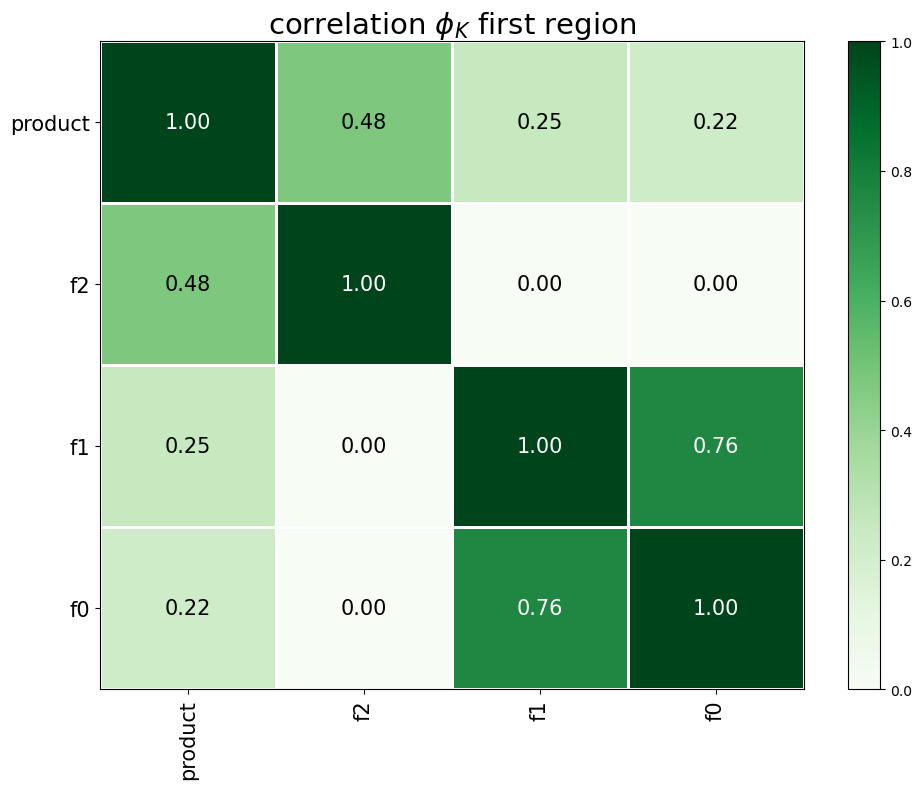

In [31]:
phik_overview = data_one.phik_matrix();
phik_overview.round(2);
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$ first region", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout();

In [32]:
corr = data_two.corr()
corr.style.pipe(make_pretty)

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


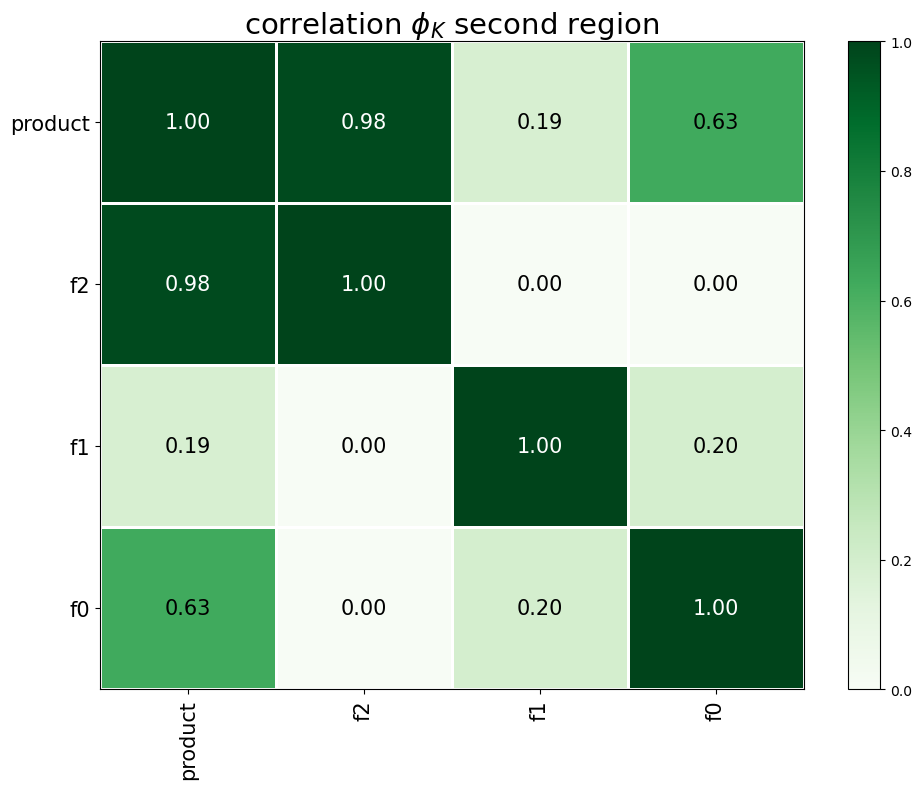

In [33]:
phik_overview = data_two.phik_matrix();
phik_overview.round(2);
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$ second region", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout();

In [34]:
corr = data_three.corr()
corr.style.pipe(make_pretty)

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


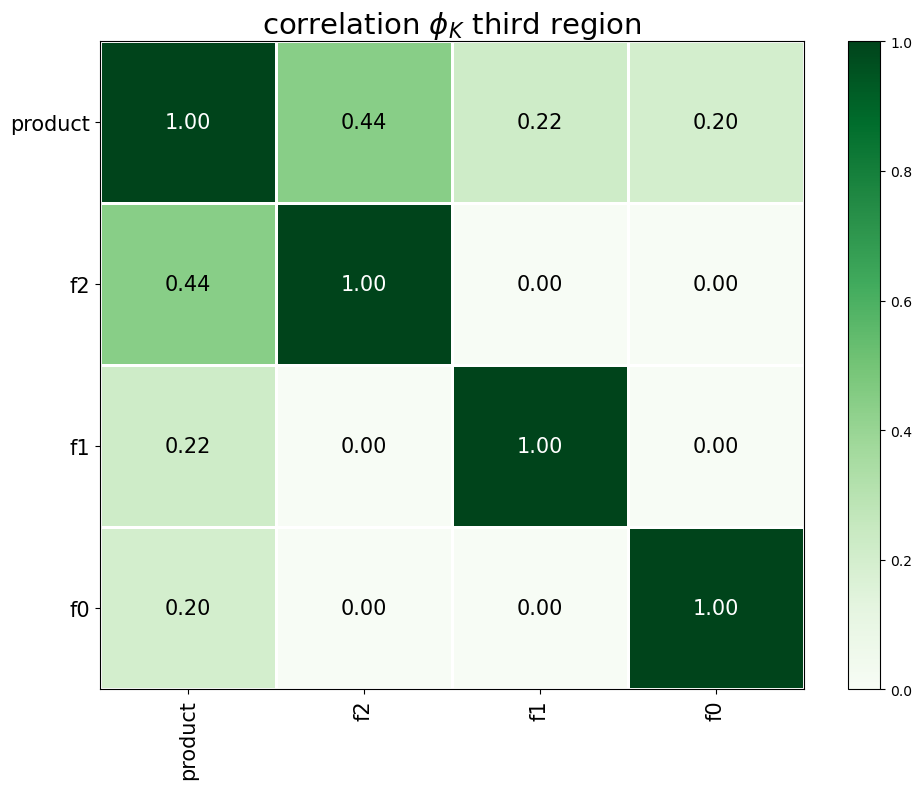

In [35]:
phik_overview = data_three.phik_matrix()
phik_overview.round(2)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$ third region", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout();

<div class="alert alert-info">
    <font size="3", color = "black"><b>✍ Вывод</b></font>
  <br><font size="3", color = "black">
    <br>
Обучена модель линейной регрессии. При исследовании данных второго региона показатель R2 равен почти 1, т.к. обладает высокой корреляцией одного из признаков с целевым, в отличии от первого и третьего региона. Метрики MSE и RMSE второго региона низкие, что говорит о том, что модель соответствует набору данных. Посчитана корреляции Пирсона и Phik. Характер взаимосвязи данных корреляции Пирсона различается с корреляцией Phik, кроме взаимосвязи product с f2. Phik обнаружала более сильную взаимосвязь, чем корреляция Пирсона.

<div class="alert alert-info">
<font size="4", color = "black"><a name="Подготовка_к_расчёту_прибыли"><h3>Подготовка к расчёту прибыли</h3></a></font>
    <br /> 
    <font size="3", color = "black">

<div class="alert alert-info">
<font size="4", color = "black">📌Объём сырья для безубыточной разработки новой скважины посчитаем по следующей формуле:
    $$V = \frac{Бюджет}{Цена\cdot Локации}$$

In [36]:
print('Объём сырья для безубыточной разработки новой скважины:', round((BUDGET / PRICE / POINT_ML), 2))

Объём сырья для безубыточной разработки новой скважины: 111.11


In [37]:
print('Средний объем запасов скважины в 1-м регионе: ', round(data_one['product'].mean(), 2))
print('Средний объем запасов скважины в 2-м регионе: ', round(data_two['product'].mean(), 2))
print('Средний объем запасов скважины в 3-м регионе: ', round(data_three['product'].mean(), 2))

Средний объем запасов скважины в 1-м регионе:  92.5
Средний объем запасов скважины в 2-м регионе:  68.83
Средний объем запасов скважины в 3-м регионе:  95.0


<div class="alert alert-info">
    <font size="3", color = "black"><b>✍ Вывод</b></font>
  <br><font size="3", color = "black">
    <br>
Объём сырья для безубыточной разработки новой скважины равен 111.11. Первый и третий регион лидирует по среднему объему запасов скважины среди исследованных регионов. Средний объем запасов скважины в первом и третьем регионе отличается от объёма сырья для безубыточной разработки новой скважины в 1.2 и 1.16 раза. Сильно отличается разница 2-ого региона, т.к. объём сырья для безубыточной разработки новой скважины в 1.6 раза больше ее, с другой стороны модель очень хорошо прогнозирует запасы скважин именно в этом регионе. 

<div class="alert alert-info">
<font size="4", color = "black"><a name="Функция_для_расчёта_прибыли_по_выбранным_скважинам"><h3>Функция для расчёта прибыли по выбранным скважинам</h3></a></font>
    <br /> 
    <font size="3", color = "black">

In [38]:
def profit(target, predictions):
    probs_sorted = predictions.sort_values(ascending=False)
    deposits = target[probs_sorted.index][:200]
    return PRICE * deposits.sum() - BUDGET

In [39]:
prediction_one = linear_reg(features_train_one, target_train_one, features_valid_one, target_valid_one)
prediction_two = linear_reg(features_train_two, target_train_two, features_valid_two, target_valid_two)
prediction_three = linear_reg(features_train_three, target_train_three, features_valid_three, target_valid_three)

In [40]:
profit_one = profit(target_valid_one, prediction_one)
profit_two = profit(target_valid_two, prediction_two)
profit_three = profit(target_valid_three, prediction_three)
print('Расчёт прибыли по выбранным скважинам по первому региону', '{:,}'.format(round(profit_one, 2)), "руб.")
print('Расчёт прибыли по выбранным скважинам по второму региону', '{:,}'.format(round(profit_two, 2)), "руб.")
print('Расчёт прибыли по выбранным скважинам по третьему региону', '{:,}'.format(round(profit_three, 2)), "руб.")

Расчёт прибыли по выбранным скважинам по первому региону 3,359,141,114.46 руб.
Расчёт прибыли по выбранным скважинам по второму региону 2,415,086,696.68 руб.
Расчёт прибыли по выбранным скважинам по третьему региону 2,598,571,759.37 руб.


<div class="alert alert-info">
<font size="4", color = "black"><a name="Риски_и_прибыль_для_каждого_региона"><h3>Риски и прибыль для каждого региона</h3></a></font>
    <br /> 
    <font size="3", color = "black">

In [41]:
def super_bootsrtap(target, predictions):
    '''функция генерирует 1000 выборок, чтобы найти распределение прибыли'''
    state = np.random.RandomState(12345)

    values = []
    for i in range(1000):
        some_target = target.sample(POINT_EDA, replace = True, random_state = state)
        some_predictions = predictions[some_target.index]
        some_target = some_target.reset_index(drop = True)
        some_predictions = some_predictions.reset_index(drop = True)
        values.append(profit(some_target, some_predictions))

    values = pd.Series(values)
    return values 

In [42]:
distribution_of_profits_one  = super_bootsrtap(target_valid_one, prediction_one)
distribution_of_profits_two  = super_bootsrtap(target_valid_two, prediction_two)
distribution_of_profits_three  = super_bootsrtap(target_valid_three, prediction_three)

In [43]:
def mean(distribution_of_profits):
    mean = distribution_of_profits.mean()
    mean = round(mean, 2)
    return mean

Первый регион
Средняя прибыль : 406,278,783.42 руб.
95%-й Доверительный интервал: -117,742,136.49 руб. - 911,737,050.75 руб.
Риск убытков: 6.7 %


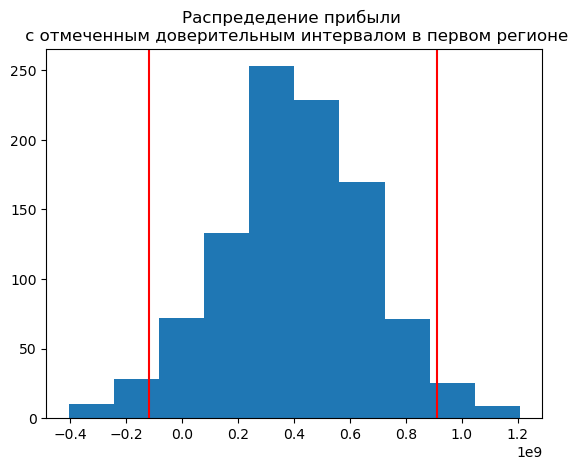

In [44]:
print("Первый регион")
print("Средняя прибыль :", '{:,}'.format(mean(distribution_of_profits_one)), "руб.")
print("95%-й Доверительный интервал:", '{:,}'.format(round(distribution_of_profits_one.quantile(0.025), 2)),
      "руб.", '-', '{:,}'.format(round(distribution_of_profits_one.quantile(0.975), 2)), "руб.")
print("Риск убытков:", st.percentileofscore(distribution_of_profits_one, 0), '%')
plt.hist(distribution_of_profits_one)
plt.title('Распредедение прибыли \n с отмеченным доверительным интервалом в первом регионе')
plt.axvline(x=distribution_of_profits_one.quantile(0.025), color='r')
plt.axvline(x=distribution_of_profits_one.quantile(0.975), color='r');

Второй регион
Средняя прибыль : 432,624,131.81 руб.
95%-й Доверительный интервал: 16,846,174.93 руб. - 815,972,526.29 руб.
Риск убытков: 2.0 %


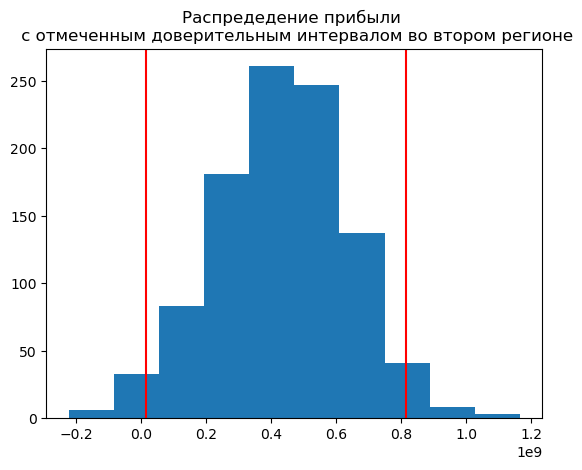

In [45]:
print("Второй регион")
print("Средняя прибыль :", '{:,}'.format(mean(distribution_of_profits_two)), "руб.")
print("95%-й Доверительный интервал:", '{:,}'.format(round(distribution_of_profits_two.quantile(0.025), 2)),
      "руб.", '-', '{:,}'.format(round(distribution_of_profits_two.quantile(0.975), 2)), "руб.")
print("Риск убытков:", round(st.percentileofscore(distribution_of_profits_two, 2), 0), '%')
plt.hist(distribution_of_profits_two)
plt.title('Распредедение прибыли \n с отмеченным доверительным интервалом во втором регионе')
plt.axvline(x=distribution_of_profits_two.quantile(0.025), color='r')
plt.axvline(x=distribution_of_profits_two.quantile(0.975), color='r');

Третий регион
Средняя прибыль : 377,362,192.42 руб.
95%-й Доверительный интервал: -170,780,417.71 руб. - 901,772,131.39 руб.
Риск убытков: 7.4 %


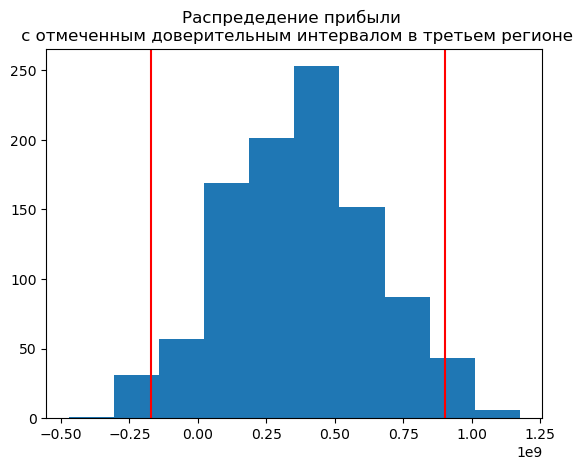

In [46]:
print("Третий регион")
print("Средняя прибыль :",'{:,}'.format(mean(distribution_of_profits_three)), "руб.")
print("95%-й Доверительный интервал:", '{:,}'.format(round(distribution_of_profits_three.quantile(0.025), 2)),
      "руб.", '-', '{:,}'.format(round(distribution_of_profits_three.quantile(0.975), 2)), "руб.")
print("Риск убытков:", st.percentileofscore(distribution_of_profits_three, 0), '%')
plt.hist(distribution_of_profits_three)
plt.title('Распредедение прибыли \n с отмеченным доверительным интервалом в третьем регионе')
plt.axvline(x=distribution_of_profits_three.quantile(0.025), color='r')
plt.axvline(x=distribution_of_profits_three.quantile(0.975), color='r');

<div class="alert alert-info">
<font size="4", color = "black"><a name="Вывод"><h3>Вывод</h3></a></font>
    <br /> 
    <font size="3", color = "black">

 <div class="alert alert-info">
    <font size="3", color = "black">
<br>Было проведено исследование, чтобы найти<b> локацию для скважины</b>. 
        
        
<br><b> Входные данные  - пробы нефти в трёх регионах. </b>

        
<br> В данных отсутствуют пропуски и дубликаты. Столбец id удален, т.к. он не требуется для исследования. Данные трех регионов разделили на обучающую и валидационную выборки, далее на признаки и целевой признак. Признаки приведены к единому масштабу для данных каждого региона.
        
<br>Были обучена модель линейной регрессии. Написана функция предсказания на основе обученной модели, затем она приведена к Series и установлена индексы. 

        
<br> Объём сырья для безубыточной разработки новой скважины равен 111, но при этом объем запасов среднестатистической скважины в регионах значительно меньше этого значения: 92.5, 68.83, 95. Средний запас региона второго региона (68.8) гораздо меньше, чем у остальных регионов и рассчитанного запаса для безубыточной разработки месторождения (111). 
        
<br>Показана функция, в которой сгенерированы 1000 выборок, чтобы найти распределение прибыли. Показана средняя прибыль, 95%-й доверительный интервал, риск убытков и распределение прибыли для трех регионов по предсказаниям модели линейной регрессии. Лучший прогноз дает второй регион, т.к. риск убытков всего 2%. Худшие прогнозы показали первый и третий регионы - 6.7 и 7.4%. 
 
<br><b>Исходя из этого, сделан вывод:
<br>         - предложен второй регион для выбора локации скважины, т.к. риск убытков мал. </b>